In [18]:
%load_ext autoreload
%autoreload 2

import pickle

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch

from seqme import ModelCache, compute_metrics, show_table
from seqme.models import Charge, Hydrophobicity
from seqme.plots import plot_embeddings, plot_kde, tsne
from seqme.utils import random_subset, read_fasta_file, shuffle_sequences

import modlamp.descriptors
import modlamp.analysis
import modlamp.sequences

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
DATASET_PATHS = {
    "UniProt": "../data/amp_data/uniprotkb_length_1_TO_200_AND_reviewed_2025_09_10.fasta",
    "AMPs": "../data/amp_data/amp_positives.fasta",
}
datasets = {name: read_fasta_file(path) for name, path in DATASET_PATHS.items()}

for model_name, sequences in datasets.items():
    print(f"{model_name}: {len(sequences)} sequences")

UniProt: 179880 sequences
AMPs: 20313 sequences


In [42]:
def has_non_standard_aa(seq):
    standard_aa = set("ACDEFGHIKLMNPQRSTVWY")
    return any(residue not in standard_aa for residue in seq)

datasets['UniProt'] = [seq for seq in datasets['UniProt'] if not has_non_standard_aa(seq)]

In [43]:
sources = [
    "UniProt",
    "AMPs"
]

n_samples = 20_000
seed = 42

benchmark_datasets = {
    source: random_subset(datasets[source], n_samples=n_samples, seed=seed)
    if len(datasets[source]) > n_samples
    else datasets[source]
    for source in sources
}

In [44]:
def calculate_hydrophobicity(data: list):
    h = modlamp.analysis.GlobalAnalysis(data)
    h.calc_H(scale="eisenberg")
    return list(h.H)

def calculate_charge(data: list):
    h = modlamp.analysis.GlobalAnalysis(data)
    h.calc_charge()
    return h.charge

In [59]:
charge_values_uniprot = calculate_charge(benchmark_datasets["UniProt"])[0]
hydrophobicity_values_uniprot = calculate_hydrophobicity(benchmark_datasets["UniProt"])[0]

In [61]:
max(hydrophobicity_values_uniprot)

np.float64(0.9500000000000001)

In [60]:
charge_values_amp = calculate_charge(benchmark_datasets["AMPs"])[0]
hydrophobicity_values_amp = calculate_hydrophobicity(benchmark_datasets["AMPs"])[0]

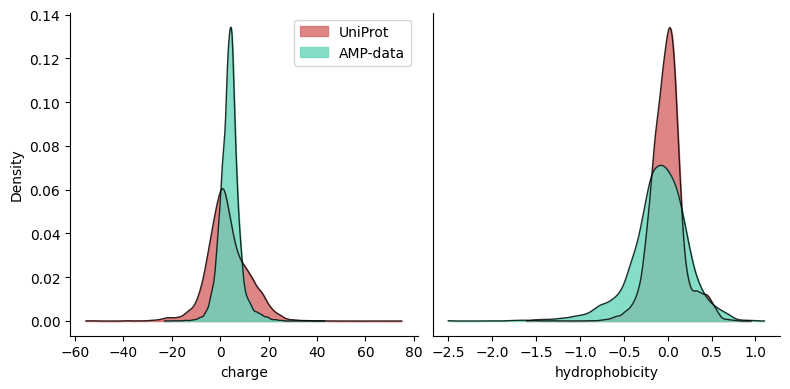

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

plot_kde(charge_values_uniprot[0], "charge", bandwidth="silverman", ax=axes[0], color="#d66868", label="UniProt")
plot_kde(charge_values_amp[0], "charge", bandwidth="silverman", ax=axes[0], label="AMP-data")
axes[0].spines["top"].set_visible(False)
axes[0].spines["right"].set_visible(False)

plot_kde(hydrophobicity_values_uniprot[0], "hydrophobicity", bandwidth="silverman", ax=axes[1], color="#d66868")
plot_kde(hydrophobicity_values_amp[0], "hydrophobicity", bandwidth="silverman", ax=axes[1])
axes[1].get_yaxis().set_visible(False)
axes[1].spines["top"].set_visible(False)
axes[1].spines["right"].set_visible(False)

fig.tight_layout()

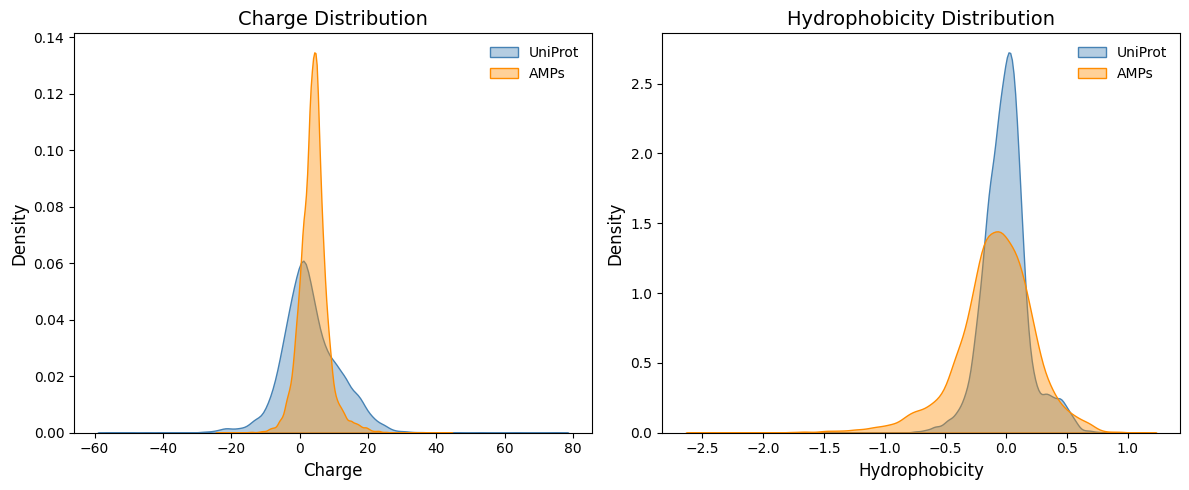

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.kdeplot(charge_values_uniprot, label="UniProt", color="steelblue", fill=True, alpha=0.4, ax=axes[0])
sns.kdeplot(charge_values_amp, label="AMPs", color="darkorange", fill=True, alpha=0.4, ax=axes[0])
axes[0].set_title("Charge Distribution", fontsize=14)
axes[0].set_xlabel("Charge", fontsize=12)
axes[0].set_ylabel("Density", fontsize=12)
axes[0].legend(frameon=False)

sns.kdeplot(hydrophobicity_values_uniprot, label="UniProt", color="steelblue", fill=True, alpha=0.4, ax=axes[1])
sns.kdeplot(hydrophobicity_values_amp, label="AMPs", color="darkorange", fill=True, alpha=0.4, ax=axes[1])
axes[1].set_title("Hydrophobicity Distribution", fontsize=14)
axes[1].set_xlabel("Hydrophobicity", fontsize=12)
axes[1].set_ylabel("Density", fontsize=12)
axes[1].legend(frameon=False)

plt.tight_layout()
plt.show()